# TWO CLASS SYM PROBLEM EXAMPLE

In [1]:
library(tidyverse) # for data manipulation
library(caret) # for model-building
library(DMwR) # for smote implementation
library(purrr) # for functional programming (map)
library(pROC) # for AUC calculations
library(doMC)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift

Loading required package: grid
Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Type 'citation("pROC")' for a citation.

Attach

In [2]:
set.seed(3000)
imbal_train <- twoClassSim(5000,
                           intercept = -30,
                           linearVars = 10,
                           noiseVars = 40)
imbal_test  <- twoClassSim(5000,
                           intercept = -30,
                           linearVars = 10,
                           noiseVars = 40)
  
prop.table(table(imbal_train$Class))


Class1 Class2 
0.9952 0.0048 

Projecting into 2 D.

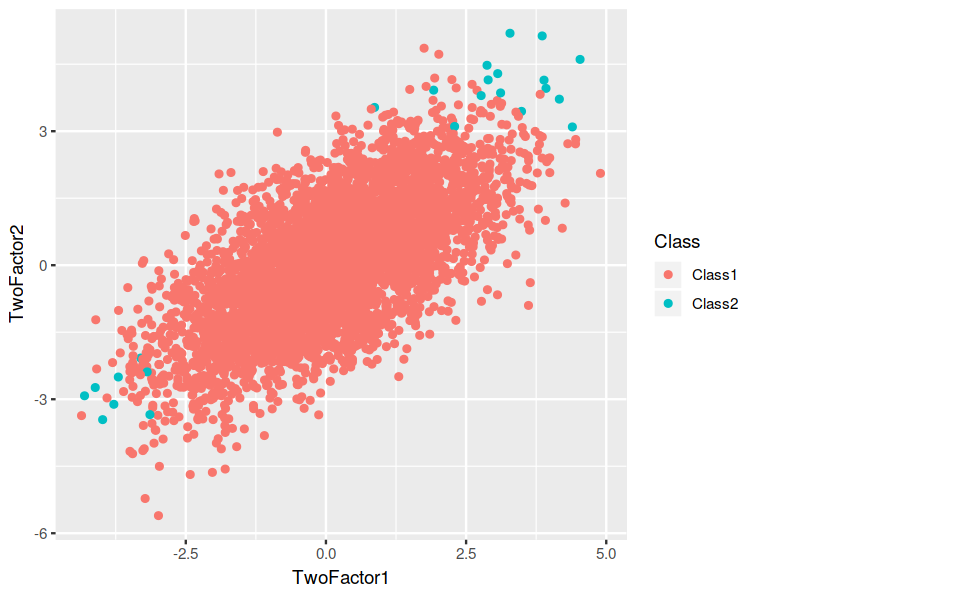

In [4]:
options(repr.plot.width=8, repr.plot.height=5)
ggplot(imbal_train, aes(x=TwoFactor1, y=TwoFactor2, color = Class)) + geom_point()

Seeing the class imbalance.

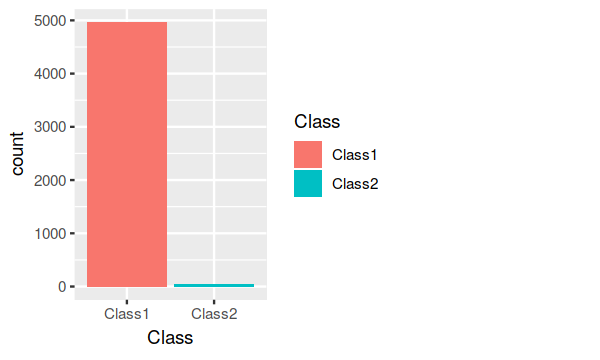

In [7]:
options(repr.plot.width=5, repr.plot.height=3)
ggplot(imbal_train, 
       aes(x = Class, 
           fill = Class)) + 
  geom_bar(position = "stack")

Reverse the levels for the modeling part.

In [3]:
imbal_train$Class <- factor(imbal_train$Class , levels = rev(levels(imbal_train$Class )))
imbal_test$Class <- factor(imbal_test$Class , levels = rev(levels(imbal_test$Class)))

# Modeling part

In [4]:
fiveStats <- function(...) c(twoClassSummary(...), 
                          defaultSummary(...))

fourStats <- function(data, lev = levels(data$obs), model = NULL){
    accKappa <- postResample(data[, "pred"], data[, "obs"])
    out <- c(accKappa,
            sensitivity(data[, "pred"], data[,"obs"],lev[1]),
            specificity(data[, "pred"], data[,"obs"],lev[2]))
    names(out)[3:4] <- c("Sens", "Spec")
    out
}
ctrl <- trainControl(method = "cv",
                    classProbs = TRUE,
                    summaryFunction = fiveStats,
                    verboseIter = TRUE,
                    savePred = TRUE
                    )
ctrlNoprob <- ctrl
ctrlNoprob$summaryFunction <- fourStats
ctrlNoprob$classProbs <- FALSE

In [5]:
set.seed(2000)
registerDoMC(cores = 3)
rfFit <- train(Class ~ ., data = imbal_train,
               method = "rf",
               trControl = ctrl,
               ntree = 500,
               tuneLength = 10,
               metric = "Accuracy")

In [13]:
lrFit <- train(Class ~ ., data = imbal_train,
               method = "glm",
               family = "binomial",
               trControl = ctrl,
               metric = "Accuracy" )

Aggregating results
Fitting final model on full training set


In [18]:
set.seed(2000)
registerDoMC(cores = 3)
knnFit <- train(Class ~ ., data = imbal_train,
               method = "knn",
               trControl = ctrl,
               tuneLength = 10,
               metric = "Accuracy")

Aggregating results
Selecting tuning parameters
Fitting k = 23 on full training set


Trying to optimize with respect to the ROC.

In [6]:
set.seed(2000)
registerDoMC(cores = 3)
rfFitROC <- train(Class ~ ., data = imbal_train,
               method = "rf",
               trControl = ctrl,
               ntree = 500,
               tuneLength = 10,
               metric = "ROC")

Aggregating results
Selecting tuning parameters
Fitting mtry = 13 on full training set


In [11]:
table(imbal_train$Class)


Class2 Class1 
    24   4976 

In [9]:
rfFitROC

Random Forest 

5000 samples
  55 predictor
   2 classes: 'Class2', 'Class1' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 4499, 4500, 4500, 4500, 4500, 4500, ... 
Resampling results across tuning parameters:

  mtry  ROC        Sens       Spec       Accuracy   Kappa    
   2    0.9554243  0.0000000  1.0000000  0.9952004  0.0000000
   7    0.9493557  0.0000000  1.0000000  0.9952004  0.0000000
  13    0.9701756  0.1333333  0.9997992  0.9956000  0.1827376
  19    0.9542682  0.2666667  0.9995984  0.9960004  0.3124905
  25    0.9447357  0.2333333  0.9993972  0.9956004  0.2623400
  31    0.9464773  0.3333333  0.9991964  0.9960000  0.3918256
  37    0.9471643  0.3500000  0.9991964  0.9960000  0.4085536
  43    0.9482692  0.3333333  0.9991964  0.9960000  0.3918256
  49    0.9256791  0.3833333  0.9989952  0.9960000  0.4582217
  55    0.9423289  0.3833333  0.9989952  0.9960000  0.4582217

ROC was used to select the optimal model using the largest value.
The

In [18]:
evalResults <- data.frame(Class = imbal_test$Class)
evalResults$RFROC <- predict(rfFitROC,
       newdata = imbal_test,
       type = "prob")[,1]

In [25]:
rocrfroc <- roc(imbal_test$Class, evalResults$RFROC,
   levels = rev(levels(imbal_test$Class)))
rfrocThreshC <- coords(rocrfroc, x = "best", best.method = "closest.topleft", transpose = FALSE)
rfrocThreshC

Setting direction: controls < cases


threshold,specificity,sensitivity
0.047,0.9839067,0.9655172


In [27]:
rfrocThreshY <- coords(rocrfroc, x = "best", best.method = "youden", transpose = FALSE)
rfrocThreshY

threshold,specificity,sensitivity
0.047,0.9839067,0.9655172


# Sampling methods

In [36]:
ctrl$sampling <- NULL
set.seed(2000)
registerDoMC(cores = 3)
lr <- train(Class ~ ., data = imbal_train,
               method = "glm",
               family = "binomial",
               trControl = ctrl,
               metric = "ROC")

Aggregating results
Fitting final model on full training set


In [37]:
lr

Generalized Linear Model 

5000 samples
  55 predictor
   2 classes: 'Class2', 'Class1' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 4499, 4500, 4500, 4500, 4500, 4500, ... 
Resampling results:

  ROC        Sens  Spec       Accuracy   Kappa     
  0,7594012  0,05  0,9985936  0,9940016  0,06469207


In [28]:
ctrl$sampling <- "down"
set.seed(2000)
registerDoMC(cores = 3)
lrUp <- train(Class ~ ., data = imbal_train,
               method = "glm",
               family = "binomial",
               trControl = ctrl,
               metric = "ROC")

Aggregating results
Fitting final model on full training set


In [33]:
lrUp

Generalized Linear Model 

5000 samples
  55 predictor
   2 classes: 'Class2', 'Class1' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 4499, 4500, 4500, 4500, 4500, 4500, ... 
Addtional sampling using down-sampling

Resampling results:

  ROC        Sens  Spec       Accuracy   Kappa     
  0,6226418  0,65  0,5611266  0,5616132  0,00491405


In [30]:
ctrl$sampling <- "smote"
set.seed(2000)
registerDoMC(cores = 3)
lrSMOTE <- train(Class ~ ., data = imbal_train,
               method = "glm",
               family = "binomial",
               trControl = ctrl,
               metric = "ROC")

Aggregating results
Fitting final model on full training set


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

In [34]:
lrSMOTE

Generalized Linear Model 

5000 samples
  55 predictor
   2 classes: 'Class2', 'Class1' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 4499, 4500, 4500, 4500, 4500, 4500, ... 
Addtional sampling using SMOTE

Resampling results:

  ROC        Sens       Spec       Accuracy   Kappa     
  0,6307185  0,5333333  0,7578269  0,7568082  0,01157754


In [31]:
ctrl$sampling <- "down"
set.seed(2000)
registerDoMC(cores = 3)
lrDown <- train(Class ~ ., data = imbal_train,
               method = "glm",
               family = "binomial",
               trControl = ctrl,
               metric = "ROC")

Aggregating results
Fitting final model on full training set


In [40]:
lrDown


Generalized Linear Model 

5000 samples
  55 predictor
   2 classes: 'Class2', 'Class1' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 4499, 4500, 4500, 4500, 4500, 4500, ... 
Addtional sampling using down-sampling

Resampling results:

  ROC        Sens  Spec       Accuracy   Kappa     
  0,6226418  0,65  0,5611266  0,5616132  0,00491405


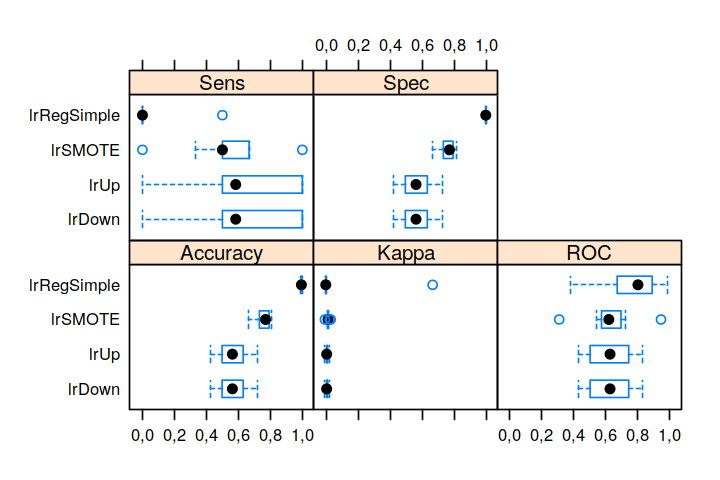

In [39]:
options(repr.plot.width=6, repr.plot.height=4)
resamp <- resamples(list(lrRegSimple = lr, 
                         lrUp = lrUp,
                         lrDown = lrDown,
                         lrSMOTE = lrSMOTE
                         )
                    )
bwplot(resamp)

In [35]:
weightsList <- list()
weights <- c(1, 50,100,500,1000,1500,2000)
for (i in 1:length(weights)){
    weightsList[[i]] <- ifelse(imbal_train$Class == "Class2", weights[i], 1)
}

In [36]:
modelWeighted <- list()
registerDoMC(cores = 3)
for(i in 1:length(weightsList)){
    set.seed(2000)
    modelWeighted[[i]]  <- train(Class ~ ., data = imbal_train,
               weights = weightsList[[i]],
               method = "glm",
               family = "binomial",
               trControl = ctrlNoprob,
               metric = "Sens")
}

Aggregating results
Fitting final model on full training set
Aggregating results
Fitting final model on full training set
Aggregating results
Fitting final model on full training set
Aggregating results
Fitting final model on full training set


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

Aggregating results
Fitting final model on full training set


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

Aggregating results
Fitting final model on full training set


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

Aggregating results
Fitting final model on full training set


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

In [42]:
metrics <- tibble(cost = rep(NA, 1, length(weightsList)),
                      Sensitivity = rep(NA, 1, length(weightsList)),
                      Specificity = rep(NA, 1, length(weightsList))
                      )
for (i in 1 : length(weightsList)){
    metrics$Sensitivity[i] <- modelWeighted[[i]]$result$Sens
    metrics$Specificity[i] <- modelWeighted[[i]]$result$Spec
    metrics$cost[i] <- weights[i]
}


In [43]:
metrics

cost,Sensitivity,Specificity
1,"0,0500000","0,9985936"
50,"0,2333333","0,9501608"
100,"0,2666667","0,9346885"
500,"0,3500000","0,8766131"
1000,"0,2666667","0,8864642"
1500,"0,3000000","0,8826251"
2000,"0,3500000","0,8774119"


In [44]:
mdf <- metrics %>%
  select(cost, Sensitivity, Specificity) %>%
  gather(key = "variable", value = "value", - cost)

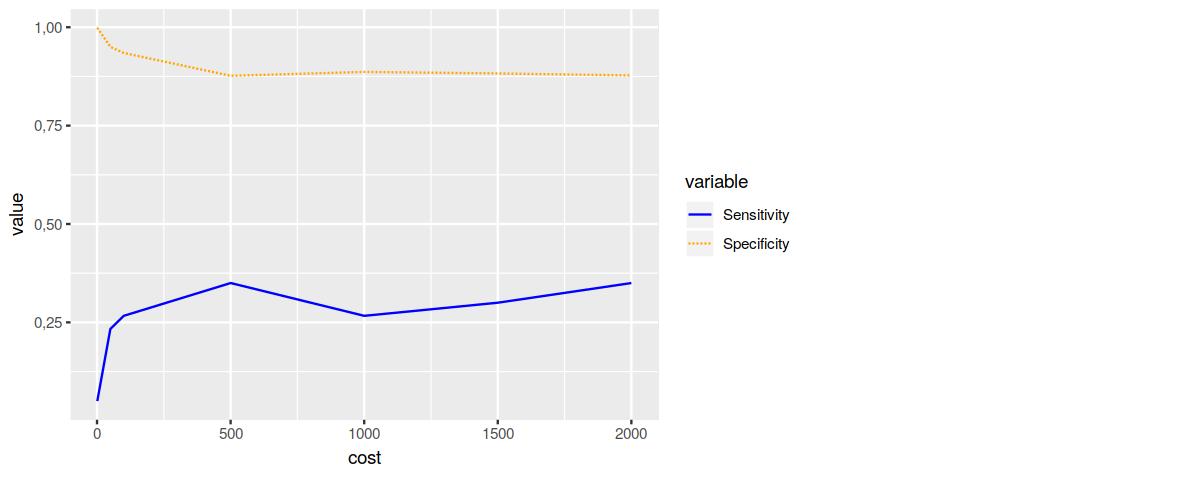

In [45]:
mdf <- metrics %>%
  select(cost, Sensitivity, Specificity) %>%
  gather(key = "variable", value = "value", - cost)
options(repr.plot.width=10, repr.plot.height=4)
ggplot(mdf, aes(x = cost, y = value)) + 
  geom_line(aes(color = variable, linetype = variable)) + 
  scale_color_manual(values = c("blue", "orange"))